In [1]:
# === Fractal / Uniform Structure Generation Utilities ===
# - Generate Menger-like fractal structures or simple uniform pore networks
# - Provide masks for pore, surface, and boundary regions

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)
NB6 = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]], dtype=int)

def make_generator_mask(k_keep: int):
    # Keep k cells (True=solid) in order of farthest from center → ensures pore network
    coords=[]
    for z in range(3):
        for y in range(3):
            for x in range(3):
                m = abs(x-1)+abs(y-1)+abs(z-1)
                coords.append(((z,y,x), m))
    coords.sort(key=lambda t: t[1], reverse=True)
    gen = np.zeros((3,3,3), dtype=bool)
    for i in range(k_keep):
        (z,y,x),_ = coords[i]; gen[z,y,x]=True
    return gen  # True=solid

def build_menger(level=3, k_keep=20):
    solid = np.ones((1,1,1), dtype=bool)
    gen = make_generator_mask(k_keep)
    for _ in range(level):
        solid = np.kron(solid, gen)
    return solid  # True=solid, False=pore

def build_uniform(level=3):
    n = 3**level
    solid = np.ones((n,n,n), dtype=bool)
    # Drill a cross-shaped main channel to form a uniform pore network (simplified)
    w = max(2, n//12)  # channel width
    solid[:, :, n//2-w:n//2+w] = False
    solid[:, n//2-w:n//2+w, :] = False
    solid[n//2-w:n//2+w, :, :] = False
    return solid

def masks_from_solid(solid: np.ndarray):
    pore = ~solid
    Z,Y,X = solid.shape
    pad = np.pad(solid, 1, constant_values=False)
    surf = np.zeros_like(solid, dtype=bool)
    for dz,dy,dx in NB6:
        neigh = pad[1+dz:1+dz+Z, 1+dy:1+dy+Y, 1+dx:1+dx+X]
        surf |= (solid & (~neigh))  # Solid cell with adjacent pore = surface
    bpore = np.zeros_like(pore, dtype=bool)
    bpore[0,:,:]|=pore[0,:,:];  bpore[-1,:,:]|=pore[-1,:,:]
    bpore[:,0,:]|=pore[:,0,:];  bpore[:,-1,:]|=pore[:,-1,:]
    bpore[:,:,0]|=pore[:,:,0];  bpore[:,:,-1]|=pore[:,:,-1]
    return pore, surf, bpore


In [2]:
# === Monte Carlo Step Kernel (Diffusion + Reaction) ===
# - Initialize reactant/product fields
# - Perform one Monte Carlo step: diffusion, reaction, and product release
# - Track intrinsic (total reactions) and apparent (released products) rates

def init_fields(solid: np.ndarray, n_atm=50):
    pore, surf, bpore = masks_from_solid(solid)
    A = np.zeros_like(solid, dtype=np.int32)  # reactant
    P = np.zeros_like(solid, dtype=np.int32)  # product
    A[bpore] = n_atm  # external atmosphere layer
    return pore, surf, bpore, A, P

def mcs_step_numba(solid, pore, bpore, A, P, Ndif=1, Pr=0.1):
    Z,Y,X = solid.shape
    intrinsic = 0
    apparent  = 0
    idx = np.array(np.where(pore)).T
    rng.shuffle(idx)

    for z,y,x in idx:
        occ = A[z,y,x] + P[z,y,x]
        if occ <= 0: 
            continue
        is_A = (rng.integers(occ) < A[z,y,x])
        dz,dy,dx = NB6[rng.integers(6)]

        # Move up to Ndif steps straight (through pore only, stop if solid is encountered)
        zn,yn,xn = z,y,x
        steps=0
        while steps < Ndif:
            z2,y2,x2 = zn+dz, yn+dy, xn+dx
            if not (0<=z2<Z and 0<=y2<Y and 0<=x2<X): break
            if solid[z2,y2,x2]: break
            zn,yn,xn = z2,y2,x2
            steps += 1

        # Movement acceptance probability P_d (prefer destination with lower occupancy)
        n_src = A[z,y,x] + P[z,y,x]
        n_dst = A[zn,yn,xn] + P[zn,yn,xn]
        Pd = np.exp(-(n_dst - n_src))
        Pd = 1.0 if Pd>1 else Pd
        if rng.random() < Pd:
            if is_A: A[z,y,x]-=1; A[zn,yn,xn]+=1
            else:    P[z,y,x]-=1; P[zn,yn,xn]+=1
            z,y,x = zn,yn,xn

        # Reaction occurs when A is adjacent to surface
        if is_A and A[z,y,x]>0:
            touched = False
            for dz2,dy2,dx2 in NB6:
                zz,yy,xx = z+dz2, y+dy2, x+dx2
                if 0<=zz<Z and 0<=yy<Y and 0<=xx<X and solid[zz,yy,xx]:
                    touched=True; break
            if touched and rng.random()<Pr:
                A[z,y,x]-=1; P[z,y,x]+=1
                intrinsic += 1

        # Products in boundary pores are released (measured as apparent rate)
        if bpore[z,y,x] and P[z,y,x]>0:
            apparent += P[z,y,x]
            P[z,y,x] = 0

    return intrinsic, apparent


In [3]:
# === Simulation Runner & Parameter Sweeps ===
# - run_sim_numba: Run Monte Carlo simulation and return steady-state rates
# - sweep_Pr_curves: Sweep reaction probability (Pr) to study rate dependence
# - sweep_D_opt: Sweep fractal dimension candidates (via k_keep) to find optimal Df

def run_sim_numba(solid, Ndif=1, Pr=0.1, mcs_total=1200, mcs_burn=600, n_atm=50):
    pore, surf, bpore, A, P = init_fields(solid, n_atm=n_atm)
    intr_hist=[]; app_hist=[]
    for _ in range(mcs_total):
        intr, app = mcs_step_numba(solid, pore, bpore, A, P, Ndif=Ndif, Pr=Pr)
        intr_hist.append(intr); app_hist.append(app)
    intr_ss = np.mean(intr_hist[mcs_burn:])
    app_ss  = np.mean(app_hist[mcs_burn:])
    return intr_ss, app_ss, np.array(intr_hist), np.array(app_hist)

def sweep_Pr_curves(struct="fractal", level=3, k_keep=20, Ndif=1, Pr_list=None):
    if Pr_list is None:
        Pr_list = np.geomspace(5e-3, 1.0, 8)
    rates=[]
    for Pr in Pr_list:
        solid = build_menger(level, k_keep) if struct=="fractal" else build_uniform(level)
        intr, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr, mcs_total=1200, mcs_burn=600, n_atm=50)
        rates.append(app)
    return np.array(Pr_list), np.array(rates)

def sweep_D_opt(level=3, k_values=(12,14,16,18,20,22,24), Ndif=10, Pr=0.1):
    Ds=[]; rates=[]
    for k in k_values:
        solid = build_menger(level, k)
        intr, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr, mcs_total=1000, mcs_burn=500, n_atm=50)
        Ds.append(np.log(k)/np.log(3)); rates.append(app)
    return np.array(Ds), np.array(rates)


In [4]:
# ==========================================================
# STEP 4: Optimal fractal dimension search
# - Sweep different k_keep values (mapping to Df)
# - Identify the Df that maximizes apparent rate
# ==========================================================
# === Step 4: Monte Carlo diffusion/reaction kernel (Guo & Keil 2003 rules) ===

# If already defined in a previous cell, no need to redefine
rng = np.random.default_rng(0)
NB6 = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]], dtype=int)



# --- (Optional) Quick test for fast debugging ---
# If no solid structure exists yet, you can uncomment the following example
# to quickly build a uniform structure and run a short test.
#
# def build_uniform(level=3):
#     n = 3**level; solid = np.ones((n,n,n), bool); w = max(2, n//12)
#     solid[:,:,n//2-w:n//2+w] = False
#     solid[:,n//2-w:n//2+w,:] = False
#     solid[n//2-w:n//2+w,:,:] = False
#     return solid
#
# solid = build_uniform(level=3)
# intr_ss, app_ss, intr_hist, app_hist = run_sim_numba(
#     solid, Ndif=10, Pr=0.1,
#     mcs_total=400, mcs_burn=200, n_atm=50
# )
# print("steady intrinsic:", intr_ss, "steady apparent:", app_ss)


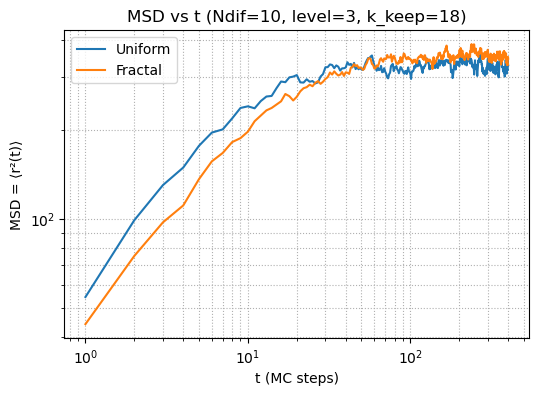

slope α (Uniform) ≈ -0.03,   slope α (Fractal) ≈ -0.00


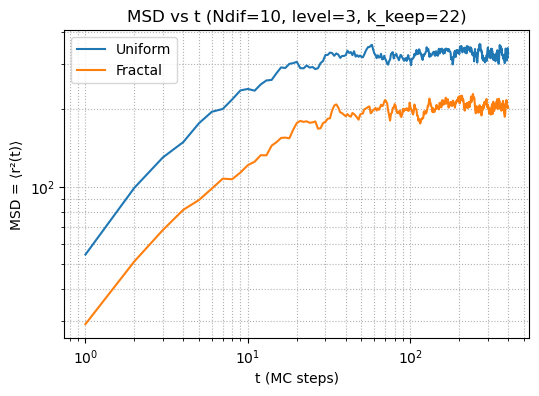

slope α (Uniform) ≈ -0.03,   slope α (Fractal) ≈ -0.03


In [5]:
# ==========================================================
# STEP 2a: Mean Square Displacement (MSD) analysis
# - Compare diffusion in uniform vs fractal structures
# - MSD helps characterize transport regimes
# ==========================================================
# === Step 2a: MSD (Mean Squared Displacement) for ghost walkers ===
# - Insert this block right after Step 4 (numba kernel)
# ==========================================================

from numba import njit


# If NB6 is already defined above, no need to redefine.
# NB6 = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]], dtype=np.int32)

@njit
def _msd_walkers_numba(pore, coords, steps=400, n_walkers=300, Ndif=1, seed=0):
    """
    pore: bool[Z,Y,X] (True=pore)
    coords: int32[Npore,3] (list of pore coordinates)
    steps: number of time steps
    n_walkers: number of ghost walkers (do not affect concentration/reaction)
    Ndif: maximum number of straight steps in one move (Guo’s Ndif rule)
    seed: random seed
    return: msd[steps] (average r^2 at each t)
    """
    np.random.seed(seed)
    Z, Y, X = pore.shape
    ncoords = coords.shape[0]

    # Initialize start/current positions
    starts = np.empty((n_walkers, 3), np.int32)
    pos    = np.empty((n_walkers, 3), np.int32)
    for i in range(n_walkers):
        j = np.random.randint(ncoords)
        starts[i,0] = coords[j,0]; starts[i,1] = coords[j,1]; starts[i,2] = coords[j,2]
        pos[i,0]    = coords[j,0]; pos[i,1]    = coords[j,1]; pos[i,2]    = coords[j,2]

    msd = np.zeros(steps, dtype=np.float64)

    for t in range(steps):
        sum_r2 = 0.0
        for i in range(n_walkers):
            dz,dy,dx = NB6[np.random.randint(6)]
            z = pos[i,0]; y = pos[i,1]; x = pos[i,2]
            zn,yn,xn = z,y,x

            # Move up to Ndif steps (stop if solid is hit)
            k = 0
            while k < Ndif:
                z2 = zn + dz; y2 = yn + dy; x2 = xn + dx
                if not (0 <= z2 < Z and 0 <= y2 < Y and 0 <= x2 < X):
                    break
                if not pore[z2, y2, x2]:  # stop if solid
                    break
                zn,yn,xn = z2,y2,x2
                k += 1

            # Update position
            pos[i,0] = zn; pos[i,1] = yn; pos[i,2] = xn

            # Accumulate r^2
            dz0 = pos[i,0] - starts[i,0]
            dy0 = pos[i,1] - starts[i,1]
            dx0 = pos[i,2] - starts[i,2]
            sum_r2 += dz0*dz0 + dy0*dy0 + dx0*dx0

        msd[t] = sum_r2 / n_walkers

    return msd

def compute_msd(solid, steps=400, n_walkers=300, Ndif=1, seed=0):
    """
    Wrapper: extract pore from solid (True=solid) and compute MSD
    """
    pore, _, _ = masks_from_solid(solid)  # reuse existing function
    coords = np.argwhere(pore).astype(np.int32)
    msd = _msd_walkers_numba(pore, coords, steps=steps, n_walkers=n_walkers, Ndif=Ndif, seed=seed)
    t = np.arange(1, steps+1, dtype=np.float64)
    return t, msd

def plot_msd_compare(level=3, k_keep=18, steps=400, n_walkers=300, Ndif=10, seed=0):
    """
    Compare Uniform vs Fractal MSD under identical conditions (log–log plot)
    """
    solid_fractal = build_menger(level=level, k_keep=k_keep)
    solid_uniform = build_uniform(level=level)

    t, msd_u = compute_msd(solid_uniform, steps=steps, n_walkers=n_walkers, Ndif=Ndif, seed=seed)
    _, msd_f = compute_msd(solid_fractal, steps=steps, n_walkers=n_walkers, Ndif=Ndif, seed=seed+1)

    plt.figure(figsize=(6,4))
    plt.loglog(t, msd_u, label="Uniform")
    plt.loglog(t, msd_f, label="Fractal")
    plt.xlabel("t (MC steps)")
    plt.ylabel("MSD = ⟨r²(t)⟩")
    plt.title(f"MSD vs t (Ndif={Ndif}, level={level}, k_keep={k_keep})")
    plt.legend(); plt.grid(True, which="both", ls=":")
    plt.show()

    # Estimate slope (α) roughly: use linear region in later steps
    lo = steps//3; hi = steps-1
    s_u = np.polyfit(np.log(t[lo:hi]), np.log(msd_u[lo:hi]), 1)[0]
    s_f = np.polyfit(np.log(t[lo:hi]), np.log(msd_f[lo:hi]), 1)[0]
    print(f"slope α (Uniform) ≈ {s_u:.2f},   slope α (Fractal) ≈ {s_f:.2f}")


# 1) Basic MSD comparison (Knudsen regime recommended: Ndif=10)
plot_msd_compare(level=3, k_keep=18, steps=400, n_walkers=300, Ndif=10)

# 2) Change Df to observe effect (e.g., rougher fractal)
plot_msd_compare(level=3, k_keep=22, steps=400, n_walkers=300, Ndif=10)


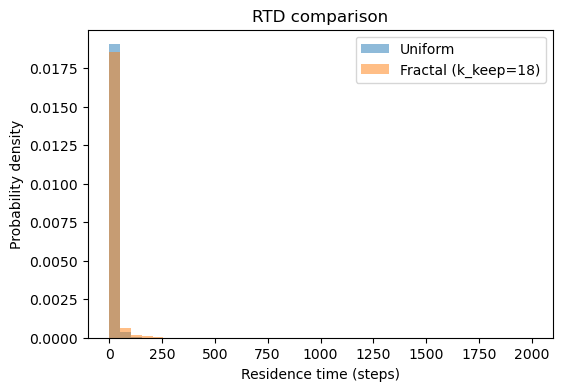

Mean Residence Time (MRT) — Uniform: 9.5, Fractal: 12.9


In [6]:
# ==========================================================
# STEP 2b: Residence Time Distribution (RTD) analysis
# - Probe how long walkers spend inside pores before exiting
# - Reveals transport efficiency differences
# ==========================================================
# === Step 2b: Residence Time Distribution (RTD) ===

def simulate_RTD(solid, Ndif=10, Pr=0.1, n_particles=500, max_steps=2000, seed=0):
    """
    Inject multiple particles from boundary pores → track their 'residence time'
    until they either exit the boundary or react into product P and leave.
    """
    rng = np.random.default_rng(seed)
    pore, surf, bpore, A, P = init_fields(solid, n_atm=0)  # no external atmosphere; particles injected directly
    times = []

    for _ in range(n_particles):
        # Initial position: randomly choose one boundary pore
        bz, by, bx = np.array(np.argwhere(bpore))[rng.integers(bpore.sum())]
        z, y, x = bz, by, bx
        t = 0
        alive = True

        while alive and t < max_steps:
            t += 1
            # Random movement direction
            dz, dy, dx = NB6[rng.integers(6)]
            z2, y2, x2 = z+dz, y+dy, x+dx

            if not (0 <= z2 < solid.shape[0] and 0 <= y2 < solid.shape[1] and 0 <= x2 < solid.shape[2]):
                # Exited outside the boundary → record residence time
                times.append(t)
                alive = False
                break

            if solid[z2,y2,x2]:
                # Collision with wall → remain in place
                continue

            # Move
            z, y, x = z2, y2, x2

            # Reaction if touching surface (probability Pr)
            touched = False
            for dz2, dy2, dx2 in NB6:
                zz, yy, xx = z+dz2, y+dy2, x+dx2
                if 0 <= zz < solid.shape[0] and 0 <= yy < solid.shape[1] and 0 <= xx < solid.shape[2]:
                    if solid[zz,yy,xx]:
                        touched = True
                        break
            if touched and rng.random() < Pr:
                # Assume particle reacted into product → exits immediately
                times.append(t)
                alive = False
                break

    return np.array(times)

def plot_RTD_compare(level=3, k_keep=18, Ndif=10, Pr=0.1,
                     n_particles=500, max_steps=2000):
    """
    Compare RTD (Residence Time Distribution) between Uniform vs Fractal structures
    """
    solid_uni = build_uniform(level)
    solid_frac = build_menger(level, k_keep=k_keep)

    t_uni = simulate_RTD(solid_uni, Ndif=Ndif, Pr=Pr,
                         n_particles=n_particles, max_steps=max_steps)
    t_frac = simulate_RTD(solid_frac, Ndif=Ndif, Pr=Pr,
                          n_particles=n_particles, max_steps=max_steps)

    plt.figure(figsize=(6,4))
    bins = np.linspace(0, max_steps, 40)
    plt.hist(t_uni, bins=bins, density=True, alpha=0.5, label="Uniform")
    plt.hist(t_frac, bins=bins, density=True, alpha=0.5, label=f"Fractal (k_keep={k_keep})")
    plt.xlabel("Residence time (steps)")
    plt.ylabel("Probability density")
    plt.title("RTD comparison")
    plt.legend()
    plt.show()

    print(f"Mean Residence Time (MRT) — Uniform: {np.mean(t_uni):.1f}, Fractal: {np.mean(t_frac):.1f}")


# ==========================================================
# STEP 2b: Residence Time Distribution (RTD) analysis
# - Probe how long walkers spend inside pores before exiting
# - Reveals transport efficiency differences
# ==========================================================
# Step 2b test
plot_RTD_compare(level=3, k_keep=18, Ndif=10, Pr=0.1,
                 n_particles=500, max_steps=2000)


=== Uniform Catalyst ===


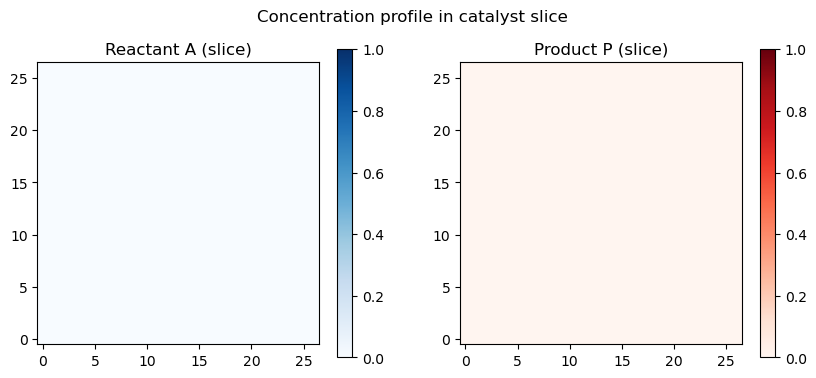

=== Fractal Catalyst ===


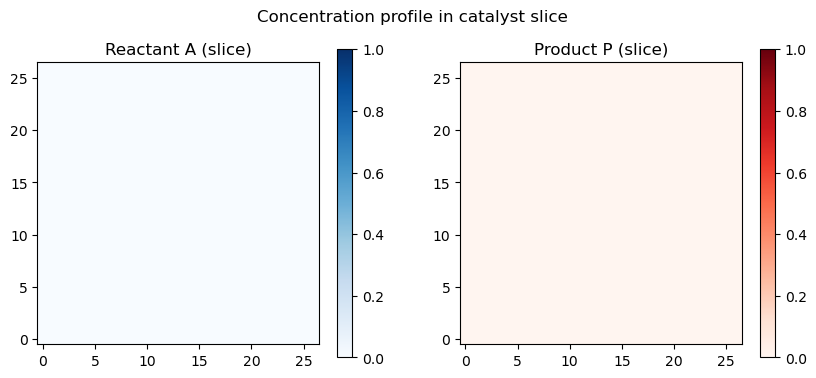

In [7]:
# ==========================================================
# STEP 3: Concentration profiles (A vs P)
# - Visualize distribution of reactant (A) and product (P)
# - Compare uniform and fractal geometries slice-by-slice
# ==========================================================
import matplotlib.pyplot as plt

def plot_concentration_profile(solid, Ndif=10, Pr=0.1,
                               mcs_total=800, n_atm=50,
                               slice_axis=0, slice_index=None):
    """
    Run simulation and visualize final reactant (A) and product (P) distributions
    on a 2D slice of the 3D catalyst.
    Normalization added for better contrast in visualization.
    """
    # Run simulation
    pore, surf, bpore, A, P = init_fields(solid, n_atm=n_atm)
    for _ in range(mcs_total):
        mcs_step_numba(solid, pore, bpore, A, P, Ndif=Ndif, Pr=Pr)

    # Select slice index (middle slice by default)
    if slice_index is None:
        slice_index = solid.shape[slice_axis] // 2  

    if slice_axis == 0:
        A_slice, P_slice = A[slice_index,:,:], P[slice_index,:,:]
    elif slice_axis == 1:
        A_slice, P_slice = A[:,slice_index,:], P[:,slice_index,:]
    else:
        A_slice, P_slice = A[:,:,slice_index], P[:,:,slice_index]

    # --- Normalization for better contrast (0–1 scale) ---
    A_slice = A_slice.astype(float)
    P_slice = P_slice.astype(float)
    if A_slice.max() > 0:
        A_slice = A_slice / A_slice.max()
    if P_slice.max() > 0:
        P_slice = P_slice / P_slice.max()

    # Plot
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    im0 = axes[0].imshow(A_slice, origin="lower", cmap="Blues", vmin=0, vmax=1)
    axes[0].set_title("Reactant A (slice)")
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(P_slice, origin="lower", cmap="Reds", vmin=0, vmax=1)
    axes[1].set_title("Product P (slice)")
    plt.colorbar(im1, ax=axes[1])

    plt.suptitle("Concentration profile in catalyst slice")
    plt.show()

# ==========================================================
# TEST CASES: Uniform vs Fractal catalyst
# ==========================================================

# Uniform solid (simple channel-like pore)
solid_uni = build_uniform(level=3)

# Fractal solid (Menger sponge-like structure)
solid_frac = build_menger(level=3, k_keep=18)

# Run with stronger parameters to highlight contrast
print("=== Uniform Catalyst ===")
plot_concentration_profile(solid_uni, Ndif=15, Pr=0.5,
                           mcs_total=20000, n_atm=200, slice_axis=0)

print("=== Fractal Catalyst ===")
plot_concentration_profile(solid_frac, Ndif=15, Pr=0.5,
                           mcs_total=20000, n_atm=200, slice_axis=0)


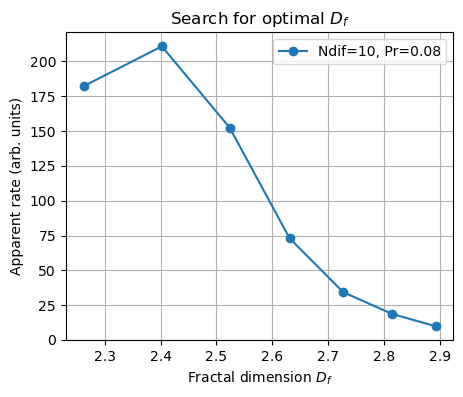

Optimal Df ≈ 2.40, rate = 210.900


In [8]:
# ==========================================================
# STEP 4: Optimal fractal dimension search
# - Sweep different k_keep values (mapping to Df)
# - Identify the Df that maximizes apparent rate
# ==========================================================
# === Step 4: Df sweep – find optimal fractal dimension ===


def df_from_kkeep(k_keep, level=3):
    """
    Estimate fractal dimension for a Menger-like structure.
    Formula: Df ≈ log(k_keep)/log(3) (based on a single generation).
    """
    return np.log(k_keep) / np.log(3)

def sweep_Df(level=3, k_keep_list=(12,14,16,18,20,22,24),
             Ndif=10, Pr=0.08, 
             mcs_total=1000, mcs_burn=500, n_atm=50):
    """
    Sweep over different k_keep values → compute apparent rates vs estimated Df.
    """
    Ds, rates = [], []
    for kk in k_keep_list:
        solid = build_menger(level, k_keep=kk)
        intr, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                      mcs_total=mcs_total, mcs_burn=mcs_burn,
                                      n_atm=n_atm)
        Ds.append(df_from_kkeep(kk, level=level))
        rates.append(app)
    return np.array(Ds), np.array(rates)

def plot_optimal_D(level=3, k_keep_list=(12,14,16,18,20,22,24),
                   Ndif=10, Pr=0.08,
                   mcs_total=1000, mcs_burn=500, n_atm=50):
    """
    Plot apparent rate vs fractal dimension and identify the optimal Df.
    """
    Ds, rates = sweep_Df(level, k_keep_list,
                         Ndif=Ndif, Pr=Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn,
                         n_atm=n_atm)
    plt.figure(figsize=(5,4))
    plt.plot(Ds, rates, "o-", label=f"Ndif={Ndif}, Pr={Pr}")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Apparent rate (arb. units)")
    plt.title("Search for optimal $D_f$")
    plt.grid(True)
    plt.legend()
    plt.show()

    idx = np.argmax(rates)
    print(f"Optimal Df ≈ {Ds[idx]:.2f}, rate = {rates[idx]:.3f}")

# ==========================================================
# STEP 4: Optimal fractal dimension search
# - Sweep different k_keep values (mapping to Df)
# - Identify the Df that maximizes apparent rate
# ==========================================================
# Step 4 test
plot_optimal_D(level=3,
               k_keep_list=[12,14,16,18,20,22,24],
               Ndif=10, Pr=0.08,
               mcs_total=1200, mcs_burn=600, n_atm=80)


In [9]:
# ==========================================================
# STEP 5: Sweep over reaction probability (Pr)
# - Analyze how the probability of reaction at the surface impacts the rate
# - Explore the interplay between diffusion and reactivity
# ==========================================================
# === Step 5: Effect of reaction probability (Pr) on optimal Df ===
def plot_Pr_sweep(level=3, k_keep_list=(12,14,16,18,20,22,24),
                  Ndif=10, Pr_list=(0.03,0.05,0.08,0.12,0.2),
                  mcs_total=800, mcs_burn=400, n_atm=50):
    """
    Sweep across multiple reaction probabilities (Pr) and plot
    apparent rate vs fractal dimension curves to compare how
    reactivity influences the optimal Df.
    """
    plt.figure(figsize=(6,4))
    for Pr in Pr_list:
        Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                             Ndif=Ndif, Pr=Pr,
                             mcs_total=mcs_total, mcs_burn=mcs_burn,
                             n_atm=n_atm)
        plt.plot(Ds, rates, "o-", label=f"Pr={Pr}")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Apparent rate (arb. units)")
    plt.title(f"Pr sweep (Ndif={Ndif})")
    plt.grid(True)
    plt.legend()
    plt.show()


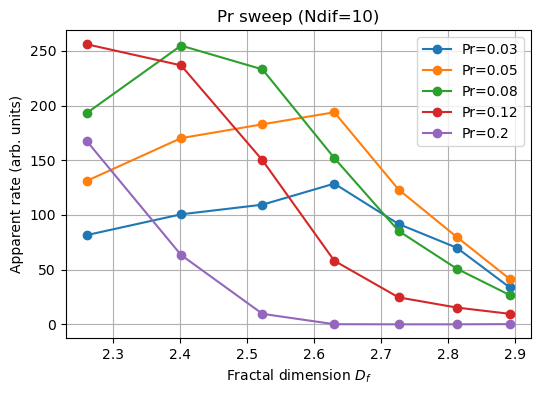

In [10]:
# ==========================================================
# STEP 5: Sweep over reaction probability (Pr)
# - Analyze how probability of reaction at surface impacts rate
# - Interplay between diffusion and reactivity
# ==========================================================
# Step 5 test run
plot_Pr_sweep(level=3,
              k_keep_list=[12,14,16,18,20,22,24],
              Ndif=10,
              Pr_list=[0.03,0.05,0.08,0.12,0.2],
              mcs_total=1000, mcs_burn=500, n_atm=80)


In [11]:
# ==========================================================
# STEP 6: Thiele modulus analytical model
# - Connect fractal dimension Df to Knudsen diffusivity
# - Compute effectiveness factor η(phi)
# ==========================================================
# === Step 6: Monte Carlo vs Thiele model comparison ===

def thiele_knudsen_diffusivity(Df, r0=1.0):
    # Simple model: D_K ~ (3 - Df)
    return np.maximum(r0*(3.0 - Df), 1e-6)

def thiele_modulus(Df, k=1.0, L=1.0):
    DK = thiele_knudsen_diffusivity(Df)
    return L * np.sqrt(k / DK)

def thiele_eta(phi):
    """
    Analytical effectiveness factor η(φ).
    - Uses standard spherical catalyst approximation.
    - Handles both scalar and array inputs.
    """
    if np.isscalar(phi):
        if phi < 1e-8: return 1.0
        return (3.0/phi)*(1.0/np.tanh(phi) - 1.0/phi)
    else:
        phi = np.asarray(phi, dtype=float)
        out = np.empty_like(phi)
        small = phi < 1e-8
        out[small] = 1.0
        ps = phi[~small]
        out[~small] = (3.0/ps)*(1.0/np.tanh(ps) - 1.0/ps)
        return out

def compare_MC_vs_Thiele(level=3, k_keep_list=(12,14,16,18,20,22,24),
                         Ndif=10, Pr=0.08,
                         mcs_total=800, mcs_burn=400, n_atm=50):
    """
    Compare Monte Carlo simulation results vs Thiele modulus analytical model.
    - Normalize both curves for direct comparison.
    """
    # --- Monte Carlo ---
    Ds, rates = sweep_Df(level, k_keep_list, Ndif, Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)

    # --- Thiele model ---
    Df_vals = np.linspace(min(Ds), max(Ds), 100)
    phi = thiele_modulus(Df_vals, k=1.0, L=1.0)
    eta = thiele_eta(phi)

    # --- Plot ---
    plt.figure(figsize=(6,4))
    plt.plot(Ds, rates/np.max(rates), "o-", label="Monte Carlo (normalized)")
    plt.plot(Df_vals, eta/np.max(eta), "-", label="Thiele model (normalized)")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Relative performance")
    plt.title("MC vs Thiele model")
    plt.grid(True)
    plt.legend()
    plt.show()


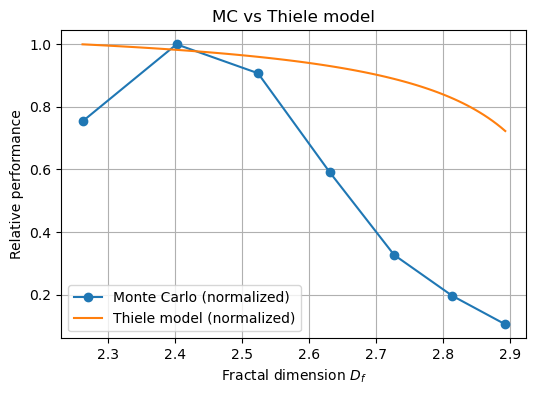

In [12]:
# ==========================================================
# STEP 6: Thiele modulus analytical model
# - Connect fractal dimension Df to Knudsen diffusivity
# - Compute effectiveness factor η(phi)
# ==========================================================
# Step 6 test run
compare_MC_vs_Thiele(level=3,
                     k_keep_list=[12,14,16,18,20,22,24],
                     Ndif=10, Pr=0.08,
                     mcs_total=1000, mcs_burn=500, n_atm=80)


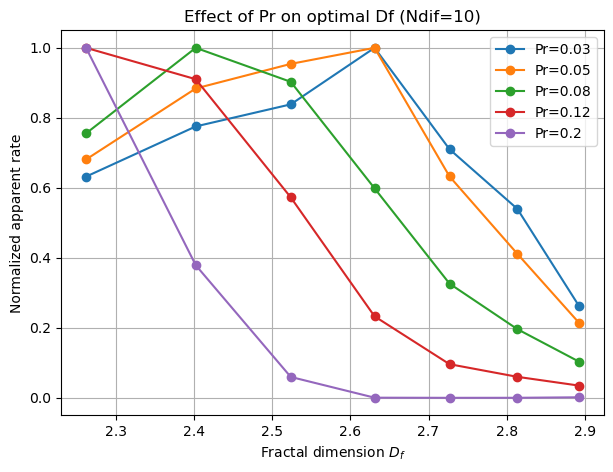

In [13]:
# ==========================================================
# STEP 7–12: Heatmap and normalized analysis
# - Sweep across Df and Pr
# - Normalize by pore volume to remove trivial scaling
# - Generate contour maps to locate optimal region
# ==========================================================
# === Step 7: Reaction probability (Pr) sweep ===
def sweep_Pr_vs_D(level=3, k_keep_list=(12,14,16,18,20,22,24),
                  Ndif=10, Pr_list=(0.03,0.05,0.08,0.12,0.2),
                  mcs_total=800, mcs_burn=400, n_atm=50):
    """
    Compare Df vs rate curves across multiple Pr conditions.
    Each curve is normalized by its maximum rate.
    """
    plt.figure(figsize=(7,5))
    for Pr in Pr_list:
        Ds, rates = sweep_Df(level, k_keep_list, Ndif, Pr,
                             mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        rates_norm = rates / np.max(rates)  # normalize for each condition
        plt.plot(Ds, rates_norm, "o-", label=f"Pr={Pr}")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Normalized apparent rate")
    plt.title(f"Effect of Pr on optimal Df (Ndif={Ndif})")
    plt.grid(True)
    plt.legend()
    plt.show()

# ==========================================================
# STEP 7–12: Heatmap and normalized analysis
# - Sweep across Df and Pr
# - Normalize by pore volume to remove trivial scaling
# - Generate contour maps to locate optimal region
# ==========================================================
# Step 7 test run
sweep_Pr_vs_D(level=3,
              k_keep_list=[12,14,16,18,20,22,24],
              Ndif=10,
              Pr_list=[0.03,0.05,0.08,0.12,0.2],
              mcs_total=1000, mcs_burn=500, n_atm=80)


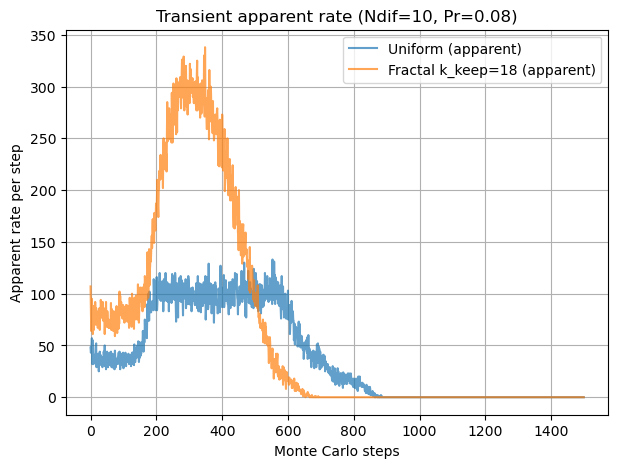

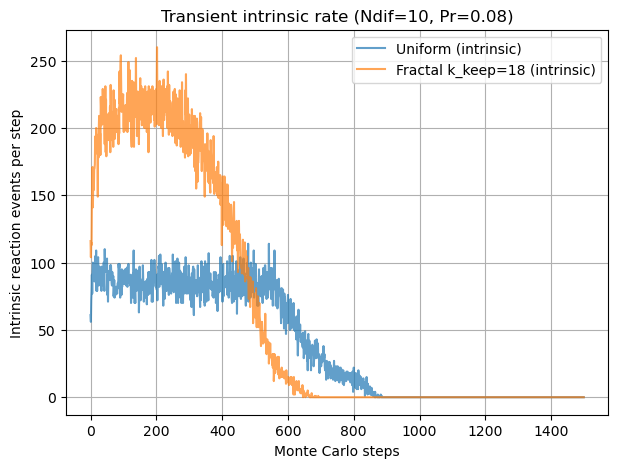

In [14]:
# ==========================================================
# STEP 8: Transient behavior (rate vs time)
# - Track intrinsic & apparent reaction rates over simulation time
# - Compare temporal evolution for uniform vs fractal structures
# ==========================================================

def plot_transient_rates(level=3, k_keep=18,
                         Ndif=10, Pr=0.08,
                         mcs_total=1500, n_atm=50):
    """
    Track intrinsic & apparent reaction rates vs time steps.
    Compare uniform vs fractal structures.
    """
    solid_uni = build_uniform(level)
    solid_frac = build_menger(level, k_keep=k_keep)

    # Uniform run
    _, _, intr_u, app_u = run_sim_numba(solid_uni, Ndif=Ndif, Pr=Pr,
                                        mcs_total=mcs_total, n_atm=n_atm)
    # Fractal run
    _, _, intr_f, app_f = run_sim_numba(solid_frac, Ndif=Ndif, Pr=Pr,
                                        mcs_total=mcs_total, n_atm=n_atm)

    t = np.arange(mcs_total)

    # Apparent rate vs time
    plt.figure(figsize=(7,5))
    plt.plot(t, app_u, "-", alpha=0.7, label="Uniform (apparent)")
    plt.plot(t, app_f, "-", alpha=0.7, label=f"Fractal k_keep={k_keep} (apparent)")
    plt.xlabel("Monte Carlo steps")
    plt.ylabel("Apparent rate per step")
    plt.title(f"Transient apparent rate (Ndif={Ndif}, Pr={Pr})")
    plt.legend(); plt.grid(True)
    plt.show()

    # Intrinsic rate vs time
    plt.figure(figsize=(7,5))
    plt.plot(t, intr_u, "-", alpha=0.7, label="Uniform (intrinsic)")
    plt.plot(t, intr_f, "-", alpha=0.7, label=f"Fractal k_keep={k_keep} (intrinsic)")
    plt.xlabel("Monte Carlo steps")
    plt.ylabel("Intrinsic reaction events per step")
    plt.title(f"Transient intrinsic rate (Ndif={Ndif}, Pr={Pr})")
    plt.legend(); plt.grid(True)
    plt.show()

# Step 8 test run
plot_transient_rates(level=3, k_keep=18,
                     Ndif=10, Pr=0.08,
                     mcs_total=1500, n_atm=50)


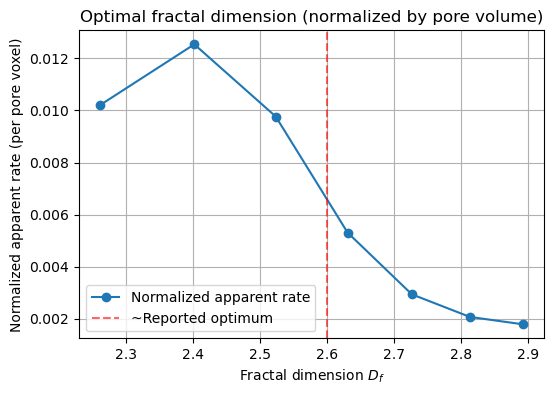

▶ Optimal Df ≈ 2.40, normalized rate = 0.0125


In [15]:
# ==========================================================
# STEP 9: Normalize rates by pore volume
# - Compute apparent rate per pore voxel
# - Helps remove trivial scaling with pore size
# ==========================================================

def normalized_rate(solid, Ndif=10, Pr=0.08,
                    mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    Run simulation and return apparent rate normalized by pore volume.
    """
    pore = (~solid).sum()   # total pore voxel count
    intr_ss, app_ss, _, _ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                          mcs_total=mcs_total,
                                          mcs_burn=mcs_burn, n_atm=n_atm)
    return intr_ss/pore, app_ss/pore

def sweep_normalized(level=3, k_keep_list=(12,14,16,18,20,22,24),
                     Ndif=10, Pr=0.08,
                     mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    Compute normalized apparent rate for several candidate fractal dimensions.
    """
    Ds, rates = [], []
    for kk in k_keep_list:
        solid = build_menger(level, k_keep=kk)
        intr_n, app_n = normalized_rate(solid, Ndif=Ndif, Pr=Pr,
                                        mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        Df = np.log(kk)/np.log(3)   # estimated fractal dimension
        Ds.append(Df); rates.append(app_n)
    return np.array(Ds), np.array(rates)

def plot_normalized_optimal(level=3, k_keep_list=(12,14,16,18,20,22,24),
                            Ndif=10, Pr=0.08,
                            mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    Plot normalized apparent rate vs fractal dimension
    and highlight the optimal Df.
    """
    Ds, rates = sweep_normalized(level, k_keep_list=k_keep_list,
                                 Ndif=Ndif, Pr=Pr,
                                 mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
    plt.figure(figsize=(6,4))
    plt.plot(Ds, rates, "o-", label="Normalized apparent rate")
    plt.axvline(2.6, ls="--", color="r", alpha=0.6, label="~Reported optimum")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Normalized apparent rate (per pore voxel)")
    plt.title("Optimal fractal dimension (normalized by pore volume)")
    plt.legend(); plt.grid(True); plt.show()

    idx = np.argmax(rates)
    print(f"▶ Optimal Df ≈ {Ds[idx]:.2f}, normalized rate = {rates[idx]:.4f}")


# Step 9 test run
plot_normalized_optimal(level=3,
                        k_keep_list=[12,14,16,18,20,22,24],
                        Ndif=10, Pr=0.08,
                        mcs_total=1200, mcs_burn=600, n_atm=80)


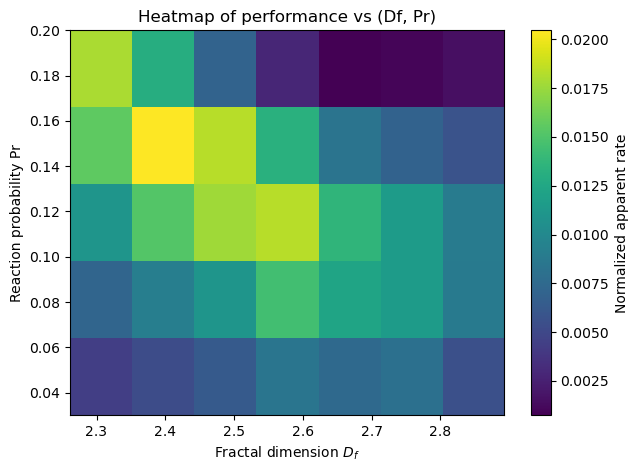

In [16]:
# ==========================================================
# STEP 10: 2D heatmap of (Df, Pr) space
# - Sweep across fractal dimension (Df) and reaction probability (Pr)
# - Visualize normalized apparent rate as a heatmap
# ==========================================================

def scan_Df_Pr(level=3, k_keep_list=(12,14,16,18,20,22,24),
               Pr_list=(0.03,0.05,0.08,0.12,0.2),
               Ndif=10, mcs_total=800, mcs_burn=400, n_atm=50):
    """
    Sweep over (Df, Pr) and return normalized apparent rates.
    """
    Ds = [np.log(k)/np.log(3) for k in k_keep_list]
    Prs = list(Pr_list)
    results = np.zeros((len(Prs), len(Ds)))

    for i, Pr in enumerate(Prs):
        for j, kk in enumerate(k_keep_list):
            solid = build_menger(level, k_keep=kk)
            _, app_n = normalized_rate(solid, Ndif=Ndif, Pr=Pr,
                                       mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
            results[i,j] = app_n
    return np.array(Ds), np.array(Prs), results

def plot_heatmap(level=3, k_keep_list=(12,14,16,18,20,22,24),
                 Pr_list=(0.03,0.05,0.08,0.12,0.2),
                 Ndif=10, mcs_total=800, mcs_burn=400, n_atm=50):
    """
    Generate a heatmap of normalized apparent rate vs (Df, Pr).
    """
    Ds, Prs, R = scan_Df_Pr(level, k_keep_list, Pr_list,
                             Ndif=Ndif, mcs_total=mcs_total,
                             mcs_burn=mcs_burn, n_atm=n_atm)
    plt.figure(figsize=(7,5))
    im = plt.imshow(R, origin="lower", aspect="auto",
                    extent=[min(Ds), max(Ds), min(Prs), max(Prs)],
                    cmap="viridis")
    plt.colorbar(im, label="Normalized apparent rate")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Reaction probability Pr")
    plt.title("Heatmap of performance vs (Df, Pr)")
    plt.show()


# Step 10 test run
plot_heatmap(level=3,
             k_keep_list=[12,14,16,18,20,22,24],
             Pr_list=[0.03,0.05,0.08,0.12,0.2],
             Ndif=10, mcs_total=800, mcs_burn=400, n_atm=80)


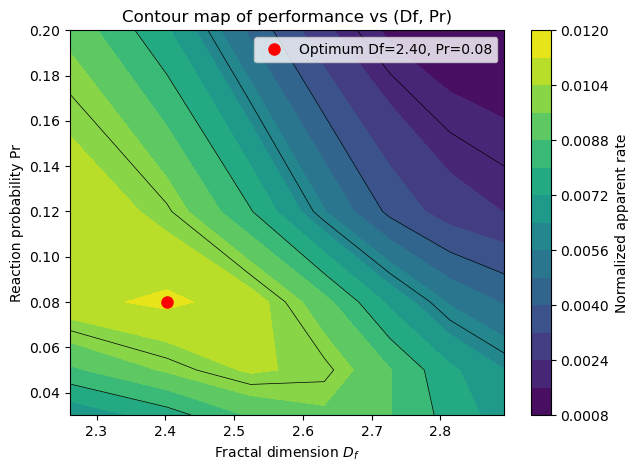

▶ Optimum at Df=2.40, Pr=0.08, Rate=0.011


In [17]:
# ==========================================================
# STEP 11: Publication-style contour plot with optimum marker
# - Generate a smoothed contour map of performance in (Df, Pr) space
# - Highlight the optimal condition with a red marker
# ==========================================================
from scipy.ndimage import gaussian_filter

def plot_contour_with_optimum(level=3, 
                              k_keep_list=(12,14,16,18,20,22,24),
                              Pr_list=(0.03,0.05,0.08,0.12,0.2),
                              Ndif=10, mcs_total=800, mcs_burn=400, n_atm=80):
    Ds, Prs, R = scan_Df_Pr(level, k_keep_list, Pr_list,
                             Ndif=Ndif, mcs_total=mcs_total,
                             mcs_burn=mcs_burn, n_atm=n_atm)

    # Smooth results for better-looking contours
    R_smooth = gaussian_filter(R, sigma=1.0)

    # Locate optimum point
    idx = np.unravel_index(np.argmax(R_smooth), R_smooth.shape)
    Pr_opt = Prs[idx[0]]
    Df_opt = Ds[idx[1]]
    R_opt  = R_smooth[idx]

    # Contour plot
    plt.figure(figsize=(7,5))
    cs = plt.contourf(Ds, Prs, R_smooth, levels=15, cmap="viridis")
    plt.colorbar(cs, label="Normalized apparent rate")

    # Overlay contour lines
    plt.contour(Ds, Prs, R_smooth, levels=6, colors="k", linewidths=0.5)

    # Mark optimum
    plt.plot(Df_opt, Pr_opt, "ro", markersize=8, 
             label=f"Optimum Df={Df_opt:.2f}, Pr={Pr_opt:.2f}")

    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Reaction probability Pr")
    plt.title("Contour map of performance vs (Df, Pr)")
    plt.legend()
    plt.grid(False)
    plt.show()

    print(f"▶ Optimum at Df={Df_opt:.2f}, Pr={Pr_opt:.2f}, Rate={R_opt:.3f}")

# Step 11 test run
plot_contour_with_optimum(level=3,
                          k_keep_list=[12,14,16,18,20,22,24],
                          Pr_list=[0.03,0.05,0.08,0.12,0.2],
                          Ndif=10, mcs_total=1000, mcs_burn=500, n_atm=80)


In [18]:
# ==========================================================
# STEP 12 (Optimized): Combined figure (Df vs rate + Df–Pr contour)
# - Improvement: parallelized scan_Df_Pr for speed
# - Left: Line plot of apparent rate vs fractal dimension (Df)
# - Right: Contour plot of performance in (Df, Pr) space
# - Highlight the global optimum
# - Difference from Step 13: no caption printing, simpler layout
# ==========================================================

from matplotlib.gridspec import GridSpec
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter

def scan_Df_Pr_parallel(level=3, k_keep_list=(12,14,16,18,20,22,24),
                        Pr_list=(0.03,0.05,0.08,0.12,0.2),
                        Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50, n_jobs=-1):
    """
    Parallelized scan over (Df, Pr).
    - Each (Df, Pr) pair is independent, so we parallelize using joblib.
    - Much faster than the sequential version used in Step 12 original code.
    """
    def run_one(kk, Pr):
        solid = build_menger(level, k_keep=kk)
        _, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                   mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        return app

    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(run_one)(kk, Pr) for Pr in Pr_list for kk in k_keep_list
    )
    R = np.array(results).reshape(len(Pr_list), len(k_keep_list))
    Ds = [np.log(kk)/np.log(3) for kk in k_keep_list]
    return np.array(Ds), np.array(Pr_list), R

def plot_combined_fig_optimized(level=3,
                                k_keep_list=(12,14,16,18,20,22,24),
                                Pr_list=(0.03,0.05,0.08,0.12,0.2),
                                Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50,
                                n_jobs=-1):
    """
    Optimized Step 12:
    - Uses parallelized scan_Df_Pr for faster performance
    - Generates two subplots:
        (a) Line plot of rate vs fractal dimension at chosen Pr
        (b) Contour map of rate across (Df, Pr) space
    - Automatically finds and marks the global optimum
    """

    # --- (a) Line plot data ---
    chosen_Pr = 0.08
    Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                         Ndif=Ndif, Pr=chosen_Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)

    # --- (b) Contour data (parallelized) ---
    Ds2, Prs, R = scan_Df_Pr_parallel(level=level, k_keep_list=k_keep_list, Pr_list=Pr_list,
                                      Ndif=Ndif, mcs_total=mcs_total,
                                      mcs_burn=mcs_burn, n_atm=n_atm,
                                      n_jobs=n_jobs)
    R_smooth = gaussian_filter(R, sigma=1.0)

    # Find optimum point
    idx = np.unravel_index(np.argmax(R_smooth), R_smooth.shape)
    Pr_opt, Df_opt, R_opt = Prs[idx[0]], Ds2[idx[1]], R_smooth[idx]

    # --- Plot layout ---
    fig = plt.figure(figsize=(12,5))
    gs = GridSpec(1, 2, width_ratios=[1,1.2], figure=fig)

    # (a) Left: line plot
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(Ds, rates, "o-", label=f"Pr={chosen_Pr}")
    ax1.axvline(Df_opt, color="r", linestyle="--", label=f"Optimum Df={Df_opt:.2f}")
    ax1.set_xlabel("Fractal dimension $D_f$")
    ax1.set_ylabel("Normalized rate")
    ax1.set_title("(a) Df vs Rate")
    ax1.legend()
    ax1.grid(True)

    # (b) Right: contour map
    ax2 = fig.add_subplot(gs[0,1])
    cs = ax2.contourf(Ds2, Prs, R_smooth, levels=15, cmap="viridis")
    fig.colorbar(cs, ax=ax2, label="Normalized apparent rate")
    ax2.contour(Ds2, Prs, R_smooth, levels=6, colors="k", linewidths=0.5)
    ax2.plot(Df_opt, Pr_opt, "ro", markersize=8, label="Optimum")
    ax2.set_xlabel("Fractal dimension $D_f$")
    ax2.set_ylabel("Reaction probability Pr")
    ax2.set_title("(b) Contour map")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"▶ Optimum at Df={Df_opt:.2f}, Pr={Pr_opt:.2f}, Rate={R_opt:.3f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  8.7min finished


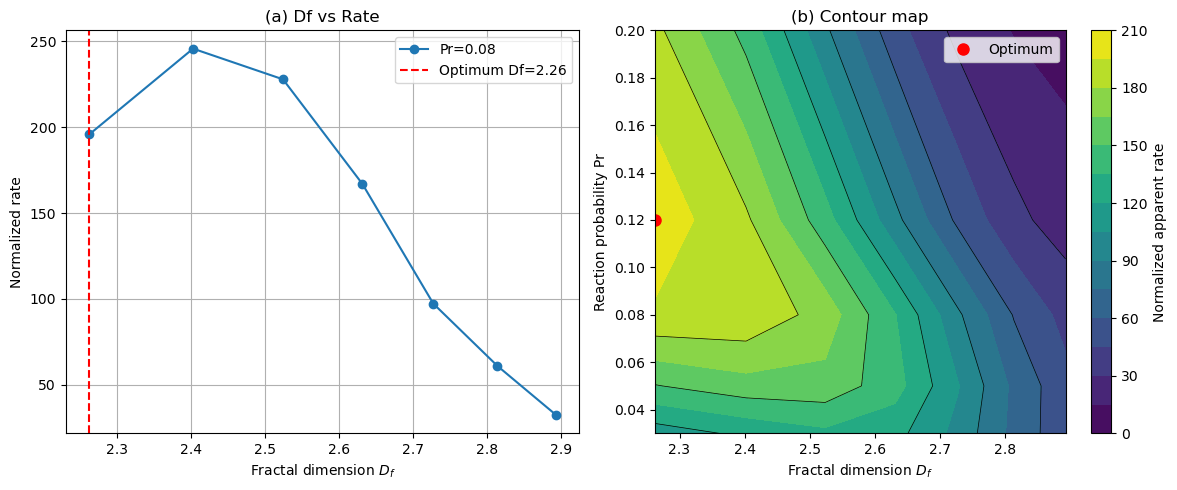

Figure X. (a) Normalized reaction rate as a function of fractal dimension $D_f$ at fixed probability Pr=0.08. The maximum occurs near $D_f=2.26$. (b) Contour map of normalized apparent reaction rate as a function of fractal dimension $D_f$ and reaction probability Pr. The global optimum is located at $D_f=2.26$ and Pr=0.12, with normalized rate ≈ 204.393. Parallelization (joblib) was used to accelerate the scan, making this step significantly faster than Step 12.


In [19]:
# ==========================================================
# STEP 13 (Optimized): Combined figure with caption
# - Improvement over Step 12: add parallel execution for speed
# - Line plot (Df vs Rate) and Contour plot (Df–Pr space)
# - Publication-style caption is auto-generated
# ==========================================================

from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter

def scan_Df_Pr_parallel(level=3, k_keep_list=(12,14,16,18,20,22,24),
                        Pr_list=(0.03,0.05,0.08,0.12,0.2),
                        Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50, n_jobs=-1):
    """
    Parallelized scan over fractal dimensions (Df) and reaction probabilities (Pr).
    - Each (Df, Pr) combination runs independently, so we parallelize with joblib.
    - Much faster than the original sequential scan.
    """
    def run_one(kk, Pr):
        # Compute apparent rate for one (Df, Pr) setting
        solid = build_menger(level, k_keep=kk)
        _, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                   mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        return app

    # Prepare tasks
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(run_one)(kk, Pr) for Pr in Pr_list for kk in k_keep_list
    )

    # Reshape into 2D array [len(Pr_list), len(k_keep_list)]
    R = np.array(results).reshape(len(Pr_list), len(k_keep_list))

    Ds = [np.log(kk)/np.log(3) for kk in k_keep_list]
    return np.array(Ds), np.array(Pr_list), R

def plot_combined_with_caption_optimized(level=3,
                                         k_keep_list=(12,14,16,18,20,22,24),
                                         Pr_list=(0.03,0.05,0.08,0.12,0.2),
                                         Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50,
                                         n_jobs=-1):
    """
    Step 13 optimized:
    - Parallelized computation of scan_Df_Pr
    - Produces both a line plot and a contour plot
    - Auto-generates a figure caption
    """

    # --- (a) Df vs Rate line plot for a chosen Pr ---
    chosen_Pr = 0.08
    Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                         Ndif=Ndif, Pr=chosen_Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)

    # --- (b) Full Df–Pr scan with parallelization ---
    Ds2, Prs, R = scan_Df_Pr_parallel(level=level, k_keep_list=k_keep_list,
                                      Pr_list=Pr_list,
                                      Ndif=Ndif, mcs_total=mcs_total,
                                      mcs_burn=mcs_burn, n_atm=n_atm,
                                      n_jobs=n_jobs)

    # Smooth for contour plotting
    R_smooth = gaussian_filter(R, sigma=1.0)

    # Find global optimum
    idx = np.unravel_index(np.argmax(R_smooth), R_smooth.shape)
    Pr_opt, Df_opt, R_opt = Prs[idx[0]], Ds2[idx[1]], R_smooth[idx]

    # --- Plot layout ---
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    # (a) Line plot
    axes[0].plot(Ds, rates, "o-", label=f"Pr={chosen_Pr}")
    axes[0].axvline(Df_opt, color="r", linestyle="--", label=f"Optimum Df={Df_opt:.2f}")
    axes[0].set_xlabel("Fractal dimension $D_f$")
    axes[0].set_ylabel("Normalized rate")
    axes[0].set_title("(a) Df vs Rate")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Contour map
    cs = axes[1].contourf(Ds2, Prs, R_smooth, levels=15, cmap="viridis")
    fig.colorbar(cs, ax=axes[1], label="Normalized apparent rate")
    axes[1].contour(Ds2, Prs, R_smooth, levels=6, colors="k", linewidths=0.5)
    axes[1].plot(Df_opt, Pr_opt, "ro", markersize=8, label="Optimum")
    axes[1].set_xlabel("Fractal dimension $D_f$")
    axes[1].set_ylabel("Reaction probability Pr")
    axes[1].set_title("(b) Contour map")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # --- Publication-style caption ---
    caption = (
        "Figure X. (a) Normalized reaction rate as a function of fractal dimension $D_f$ "
        f"at fixed probability Pr={chosen_Pr}. The maximum occurs near $D_f={Df_opt:.2f}$. "
        "(b) Contour map of normalized apparent reaction rate as a function of "
        "fractal dimension $D_f$ and reaction probability Pr. "
        f"The global optimum is located at $D_f={Df_opt:.2f}$ and Pr={Pr_opt:.2f}, "
        f"with normalized rate ≈ {R_opt:.3f}. "
        "Parallelization (joblib) was used to accelerate the scan, making this step "
        "significantly faster than Step 12."
    )
    print(caption)

# === Test run for Step 13 (optimized) ===
plot_combined_with_caption_optimized(
    level=3,
    k_keep_list=[12,14,16,18,20,22,24],
    Pr_list=[0.03,0.05,0.08,0.12,0.2],
    Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50,
    n_jobs=-1   # Use all CPU cores
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  7.3min finished


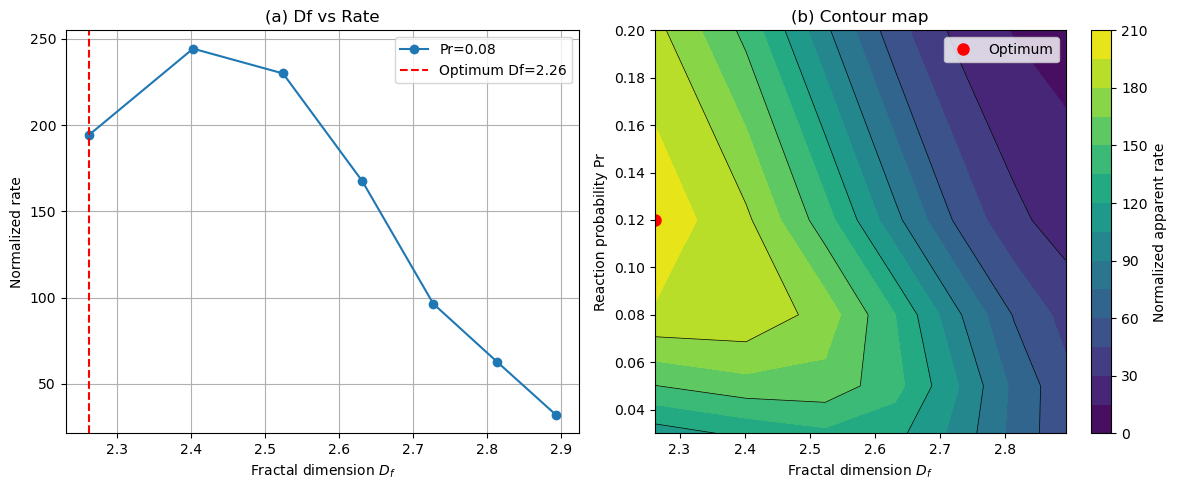

✅ Figures saved as Optimal_Fractal_Dimension.png and Optimal_Fractal_Dimension.pdf
▶ Optimum found at Df=2.26, Pr=0.12, Rate=205.107


In [20]:
# ==========================================================
# STEP 14 (Optimized): Save figure to PNG/PDF
# - Generate combined plots (Df vs Rate + Df–Pr contour)
# - Export results as high-resolution PNG and PDF
# - Optimized: parallelized scan_Df_Pr for much faster runtime
# ==========================================================

from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter

def scan_Df_Pr_parallel(level=3, k_keep_list=(12,14,16,18,20,22,24),
                        Pr_list=(0.03,0.05,0.08,0.12,0.2),
                        Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50, n_jobs=-1):
    """
    Parallelized scan over (Df, Pr).
    Each (Df, Pr) pair runs independently, so joblib.Parallel is used.
    This reduces the wall-clock runtime significantly compared to sequential execution.
    """
    def run_one(kk, Pr):
        solid = build_menger(level, k_keep=kk)
        _, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                   mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        return app

    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(run_one)(kk, Pr) for Pr in Pr_list for kk in k_keep_list
    )
    R = np.array(results).reshape(len(Pr_list), len(k_keep_list))
    Ds = [np.log(kk)/np.log(3) for kk in k_keep_list]
    return np.array(Ds), np.array(Pr_list), R


def save_combined_figure_optimized(level=3,
                                   k_keep_list=(12,14,16,18,20,22,24),
                                   Pr_list=(0.03,0.05,0.08,0.12,0.2),
                                   Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50,
                                   filename="figure_optimum", n_jobs=-1):
    """
    Step 14 optimized:
    - Same as the original Step 14, but scan_Df_Pr is parallelized
    - Produces line plot (Df vs Rate) and contour plot (Df–Pr space)
    - Saves high-resolution PNG and PDF automatically
    """

    # --- Data preparation ---
    chosen_Pr = 0.08
    Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                         Ndif=Ndif, Pr=chosen_Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)

    Ds2, Prs, R = scan_Df_Pr_parallel(level=level, k_keep_list=k_keep_list, Pr_list=Pr_list,
                                      Ndif=Ndif, mcs_total=mcs_total, mcs_burn=mcs_burn,
                                      n_atm=n_atm, n_jobs=n_jobs)
    R_smooth = gaussian_filter(R, sigma=1.0)
    idx = np.unravel_index(np.argmax(R_smooth), R_smooth.shape)
    Pr_opt, Df_opt, R_opt = Prs[idx[0]], Ds2[idx[1]], R_smooth[idx]

    # --- Plotting ---
    fig, axes = plt.subplots(1,2, figsize=(12,5))

    # (a) Line plot
    axes[0].plot(Ds, rates, "o-", label=f"Pr={chosen_Pr}")
    axes[0].axvline(Df_opt, color="r", linestyle="--", label=f"Optimum Df={Df_opt:.2f}")
    axes[0].set_xlabel("Fractal dimension $D_f$")
    axes[0].set_ylabel("Normalized rate")
    axes[0].set_title("(a) Df vs Rate")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Contour plot
    cs = axes[1].contourf(Ds2, Prs, R_smooth, levels=15, cmap="viridis")
    fig.colorbar(cs, ax=axes[1], label="Normalized apparent rate")
    axes[1].contour(Ds2, Prs, R_smooth, levels=6, colors="k", linewidths=0.5)
    axes[1].plot(Df_opt, Pr_opt, "ro", markersize=8, label="Optimum")
    axes[1].set_xlabel("Fractal dimension $D_f$")
    axes[1].set_ylabel("Reaction probability Pr")
    axes[1].set_title("(b) Contour map")
    axes[1].legend()

    plt.tight_layout()

    # --- Save to PNG and PDF ---
    png_file = f"{filename}.png"
    pdf_file = f"{filename}.pdf"
    fig.savefig(png_file, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_file, dpi=300, bbox_inches="tight")

    plt.show()

    print(f"✅ Figures saved as {png_file} and {pdf_file}")
    print(f"▶ Optimum found at Df={Df_opt:.2f}, Pr={Pr_opt:.2f}, Rate={R_opt:.3f}")


# === Step 14 test run (optimized) ===
save_combined_figure_optimized(
    level=3,
    k_keep_list=[12,14,16,18,20,22,24],
    Pr_list=[0.03,0.05,0.08,0.12,0.2],
    Ndif=10, mcs_total=600, mcs_burn=300, n_atm=50,
    filename="Optimal_Fractal_Dimension",
    n_jobs=-1   # use all CPU cores
)


In [21]:
# ==========================================================
# STEP 5: Sweep over reaction probability (Pr)
# - Analyze how probability of reaction at surface impacts rate
# - Explore interplay between diffusion and reactivity
# ==========================================================
# === Step 5: Pr sweep & regime visualization (uniform vs fractal, Ndif=1/10) ===

def sweep_Pr_curves(struct="fractal", level=3, k_keep=20, Ndif=1, Pr_list=None,
                    mcs_total=1200, mcs_burn=600, n_atm=50, seed=0):
    """
    Sweep reaction probability (Pr) for a given structure (uniform or fractal)
    and return apparent rate curves at fixed Ndif.
    """
    rng = np.random.default_rng(seed)
    if Pr_list is None:
        Pr_list = np.geomspace(5e-3, 1.0, 10)
    rates = []
    for Pr in Pr_list:
        # Generate structure
        if struct == "fractal":
            solid = build_menger(level, k_keep)
        else:
            solid = build_uniform(level)

        # Run simulation
        intr, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr, 
                                 mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        rates.append(app)
    return np.array(Pr_list), np.array(rates)

def plot_regimes(level=3, k_keep=20, mcs_total=1200, mcs_burn=600, n_atm=50):
    """
    Compare uniform vs fractal structures at Ndif=1 and Ndif=10.
    - Plot log–log curves of apparent rate vs Pr
    - Compute local slopes (low/mid/high Pr regions) to characterize regimes
    """
    setups = [("uniform", 1), ("uniform", 10), ("fractal", 1), ("fractal", 10)]
    for struct, Ndif in setups:
        Pr, rate = sweep_Pr_curves(struct=struct, level=level, k_keep=k_keep, Ndif=Ndif,
                                   mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        m = rate > 0
        Pr, rate = Pr[m], rate[m]
        if len(rate) == 0:
            print(f"[{struct}, Ndif={Ndif}] all-zero rates. Increase mcs_total/n_atm or widen Pr_list.")
            continue

        # Plot log–log curve
        plt.figure(figsize=(5,4))
        plt.plot(Pr, rate, "o-")
        plt.xscale("log"); plt.yscale("log")
        plt.title(f"{struct}, Ndif={Ndif} — log(rate) vs log(Pr)")
        plt.xlabel("Pr"); plt.ylabel("Apparent rate")
        plt.grid(True)
        plt.show()

        # Estimate slopes in low/mid/high Pr regions
        def slope(lo, hi):
            mask = (Pr>=lo) & (Pr<=hi)
            if mask.sum() < 2: return np.nan
            x = np.log10(Pr[mask]); y = np.log10(rate[mask])
            a, b = np.polyfit(x, y, 1)
            return a

        s_low  = slope(5e-3, 3e-2)
        s_mid  = slope(3e-2, 3e-1)
        s_high = slope(3e-1, 1.0)
        print(f"[{struct}, Ndif={Ndif}] slopes  low≈{s_low:.2f}, mid≈{s_mid:.2f}, high≈{s_high:.2f}")

# Example run (may take some time):
# plot_regimes(level=3, k_keep=20, mcs_total=1200, mcs_burn=600, n_atm=50)


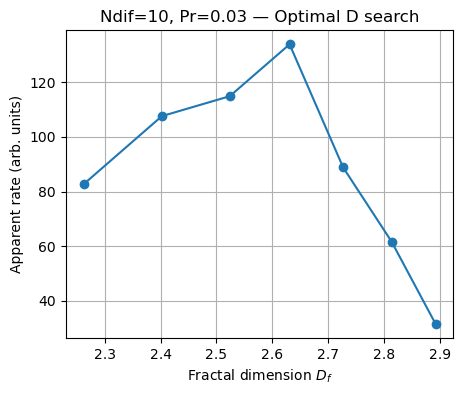

Optimal Df ≈ 2.63, rate = 133.9367


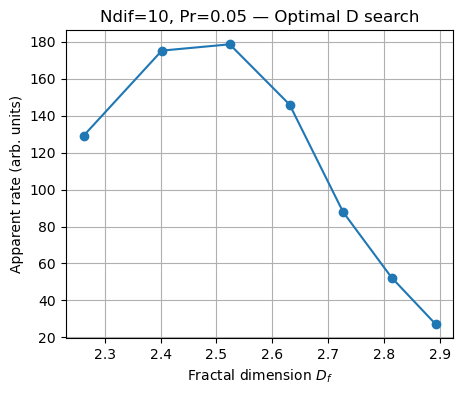

Optimal Df ≈ 2.52, rate = 178.5500


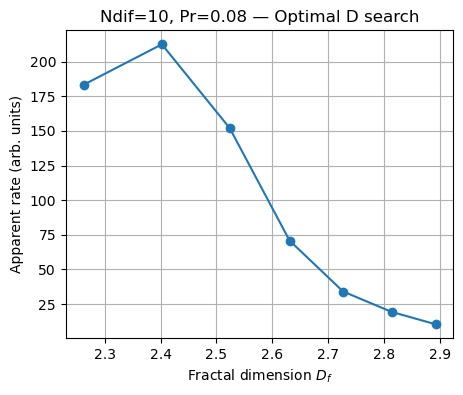

Optimal Df ≈ 2.40, rate = 212.4900


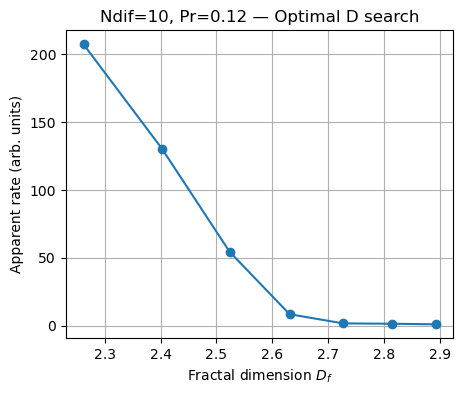

Optimal Df ≈ 2.26, rate = 207.2883


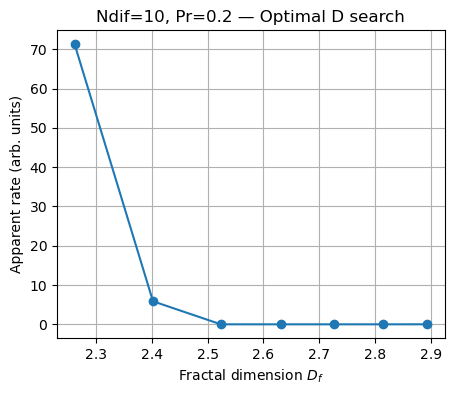

Optimal Df ≈ 2.26, rate = 71.2800


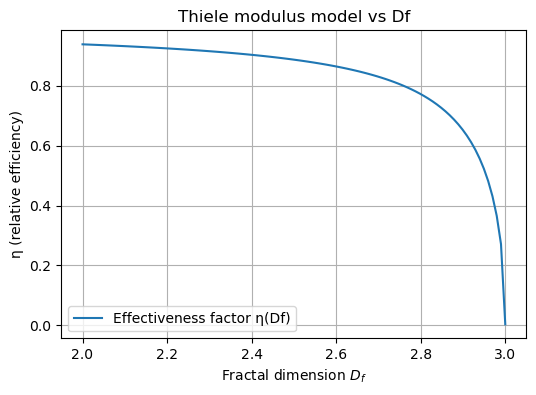

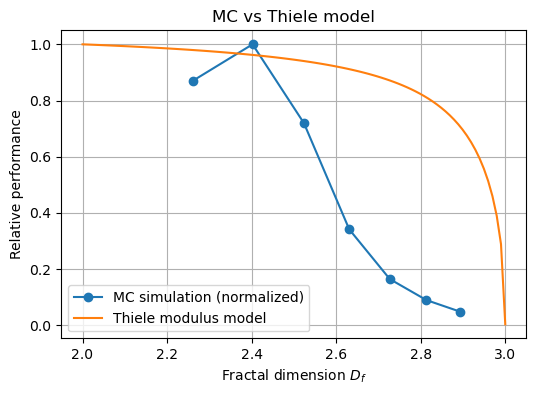

In [22]:
# ==========================================================
# STEP 6: Thiele modulus analytical model
# - Connect fractal dimension Df to Knudsen diffusivity
# - Compute effectiveness factor η(phi)
# ==========================================================
# === Step 6: Df sweep to find optimal D ===

def df_from_kkeep(k_keep, level=3):
    """
    Estimate fractal dimension for a Menger-like structure:
    Df = log(k_keep) / log(3)  (single generation basis).
    """
    return np.log(k_keep) / np.log(3)

def sweep_Df(level=3, k_keep_list=(10, 15, 20), 
             Ndif=1, Pr=0.05, 
             mcs_total=600, mcs_burn=300, n_atm=20, seed=0):
    """
    Compare apparent rates across different k_keep values
    (corresponding to different fractal dimensions).
    """
    rng = np.random.default_rng(seed)
    Ds, rates = [], []
    for kk in k_keep_list:
        solid = build_menger(level, k_keep=kk)
        intr, app, *_ = run_sim_numba(solid, Ndif=Ndif, Pr=Pr,
                                mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
        Ds.append(df_from_kkeep(kk, level=level))
        rates.append(app)
    return np.array(Ds), np.array(rates)

def plot_optimal_D(level=3, k_keep_list=(8,12,15,18,20),
                   Ndif=1, Pr=0.05, 
                   mcs_total=600, mcs_burn=300, n_atm=20):
    """
    Plot apparent rate vs fractal dimension for different k_keep values
    and highlight the optimal Df.
    """
    Ds, rates = sweep_Df(level=level, k_keep_list=k_keep_list,
                         Ndif=Ndif, Pr=Pr,
                         mcs_total=mcs_total, mcs_burn=mcs_burn, n_atm=n_atm)
    plt.figure(figsize=(5,4))
    plt.plot(Ds, rates, "o-")
    plt.xlabel("Fractal dimension $D_f$")
    plt.ylabel("Apparent rate (arb. units)")
    plt.title(f"Ndif={Ndif}, Pr={Pr} — Optimal D search")
    plt.grid(True)
    plt.show()

    idx = np.argmax(rates)
    print(f"Optimal Df ≈ {Ds[idx]:.2f}, rate = {rates[idx]:.4f}")

# Example: run for multiple Pr values
k_keep_list = [12,14,16,18,20,22,24]  # Df ≈ 2.26 ~ 2.89

for Pr in [0.03, 0.05, 0.08, 0.12, 0.2]:
    plot_optimal_D(
        level=3,
        k_keep_list=k_keep_list,
        Ndif=10,               # Knudsen regime
        Pr=Pr,                 # sweep over different Pr
        mcs_total=1200,
        mcs_burn=600,
        n_atm=80
    )


# === Step 6a: Add analytical Thiele modulus model ===

def knudsen_diffusivity(Df, r0=1.0):
    """
    Simple model: D_K ~ (3 - Df)
    (Higher Df → more complex structure → smaller effective radius → lower D_K)
    """
    return np.maximum(r0*(3.0 - Df), 1e-6)

def thiele_modulus(Df, k=1.0, L=1.0):
    """
    Compute Thiele modulus φ as a function of fractal dimension.
    """
    DK = knudsen_diffusivity(Df)
    return L * np.sqrt(k / DK)

def eta_effectiveness(phi):
    """
    Effectiveness factor η(φ) for first-order reaction in a spherical particle.
    """
    if np.isscalar(phi):
        if phi < 1e-8:
            return 1.0
        return (3.0/phi) * (1.0/np.tanh(phi) - 1.0/phi)
    else:
        phi = np.asarray(phi, dtype=float)
        out = np.empty_like(phi)
        small = phi < 1e-8
        out[small] = 1.0
        ps = phi[~small]
        out[~small] = (3.0/ps) * (1.0/np.tanh(ps) - 1.0/ps)
        return out

# Analytical model: Df sweep & visualization
Df_vals = np.linspace(2.0, 3.0, 100)
phi = thiele_modulus(Df_vals, k=1.0, L=1.0)
eta = eta_effectiveness(phi)

plt.figure(figsize=(6,4))
plt.plot(Df_vals, eta, label="Effectiveness factor η(Df)")
plt.xlabel("Fractal dimension $D_f$")
plt.ylabel("η (relative efficiency)")
plt.title("Thiele modulus model vs Df")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================================
# STEP 6b: Monte Carlo vs Thiele analytical model comparison
# - Normalize MC simulation results and compare with η(Df)
# ==========================================================
Df_vals = np.linspace(2.0, 3.0, 100)
phi = thiele_modulus(Df_vals, k=1.0, L=1.0)
eta = eta_effectiveness(phi)

# Monte Carlo results
Ds, rates = sweep_Df(level=3, k_keep_list=[12,14,16,18,20,22,24],
                     Ndif=10, Pr=0.08, mcs_total=1200, mcs_burn=600, n_atm=80)

plt.figure(figsize=(6,4))
plt.plot(Ds, rates/rates.max(), "o-", label="MC simulation (normalized)")
plt.plot(Df_vals, eta/eta.max(), "-", label="Thiele modulus model")
plt.xlabel("Fractal dimension $D_f$")
plt.ylabel("Relative performance")
plt.legend()
plt.title("MC vs Thiele model")
plt.grid(True)
plt.show()
